训练集：验证集：测试集 = 6 : 2 : 2

In [3]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models
from torch.autograd import Variable

In [4]:
# setting global parameters
modellr = 1e-4
BATCH_SIZE = 64
EPOCHS = 15
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# data preprocessing
 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
 
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [6]:
# loading data
dataset_train = datasets.ImageFolder('output2/train', transform)
print(dataset_train.imgs)
# corresponding label
print(dataset_train.class_to_idx)
dataset_val = datasets.ImageFolder('output2/val', transform_test)

print(dataset_val.class_to_idx)
dataset_test = datasets.ImageFolder('output2/test', transform_test)

print(dataset_test.class_to_idx)
 
# loading data
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

[('output2/train\\Kirmizi_Pistachio\\kirmizi (1).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (10).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (12).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (14).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (15).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (16).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (17).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (18).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (2).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (22).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (23).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (24).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (25).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (26).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (28).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (3).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (30).jpg', 0),

<h1>ResNet</h1>

In [7]:
# implement the model and move it to GPU
criterion = nn.CrossEntropyLoss()
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.to(DEVICE)
# choose the Adam
optimizer = optim.Adam(model.parameters(), lr=modellr)
 
 
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    modellrnew = modellr * (0.1 ** (epoch // 50))
    print("lr:", modellrnew)
    for param_group in optimizer.param_groups:
        param_group['lr'] = modellrnew

D:\anaconda3\envs\pytorch_py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda3\envs\pytorch_py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<h1>Training</h1>

In [7]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=EPOCHS):
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = Variable(inputs).to(DEVICE), Variable(labels).to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs.data, 1)
            corrects += torch.sum(preds == labels)
            total += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())
        
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print(f"Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = Variable(inputs).to(DEVICE), Variable(labels).to(DEVICE)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs.data, 1)
                val_corrects += torch.sum(preds == labels)
                val_total += labels.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / val_total
        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())
        
        print(f"Validation Loss: {val_loss:.4f} Validation Acc: {val_acc:.4f}")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'ResNet_best_model_pretrained-data2.pth')

    
train_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 0/14
Loss: 0.1961 Acc: 0.9177
Validation Loss: 0.3953 Validation Acc: 0.8135
Epoch 1/14
Loss: 0.0237 Acc: 0.9922
Validation Loss: 0.1514 Validation Acc: 0.9441
Epoch 2/14
Loss: 0.0270 Acc: 0.9907
Validation Loss: 0.0730 Validation Acc: 0.9744
Epoch 3/14
Loss: 0.0125 Acc: 0.9953
Validation Loss: 0.0477 Validation Acc: 0.9883
Epoch 4/14
Loss: 0.0238 Acc: 0.9930
Validation Loss: 0.0809 Validation Acc: 0.9650
Epoch 5/14
Loss: 0.0058 Acc: 0.9992
Validation Loss: 0.0383 Validation Acc: 0.9930
Epoch 6/14
Loss: 0.0038 Acc: 0.9992
Validation Loss: 0.0722 Validation Acc: 0.9720
Epoch 7/14
Loss: 0.0403 Acc: 0.9868
Validation Loss: 0.0851 Validation Acc: 0.9674
Epoch 8/14
Loss: 0.0095 Acc: 0.9969
Validation Loss: 0.0466 Validation Acc: 0.9860
Epoch 9/14
Loss: 0.0024 Acc: 1.0000
Validation Loss: 0.0451 Validation Acc: 0.9837
Epoch 10/14
Loss: 0.0013 Acc: 1.0000
Validation Loss: 0.0420 Validation Acc: 0.9837
Epoch 11/14
Loss: 0.0008 Acc: 1.0000
Validation Loss: 0.0390 Validation Acc: 0.9837
Ep

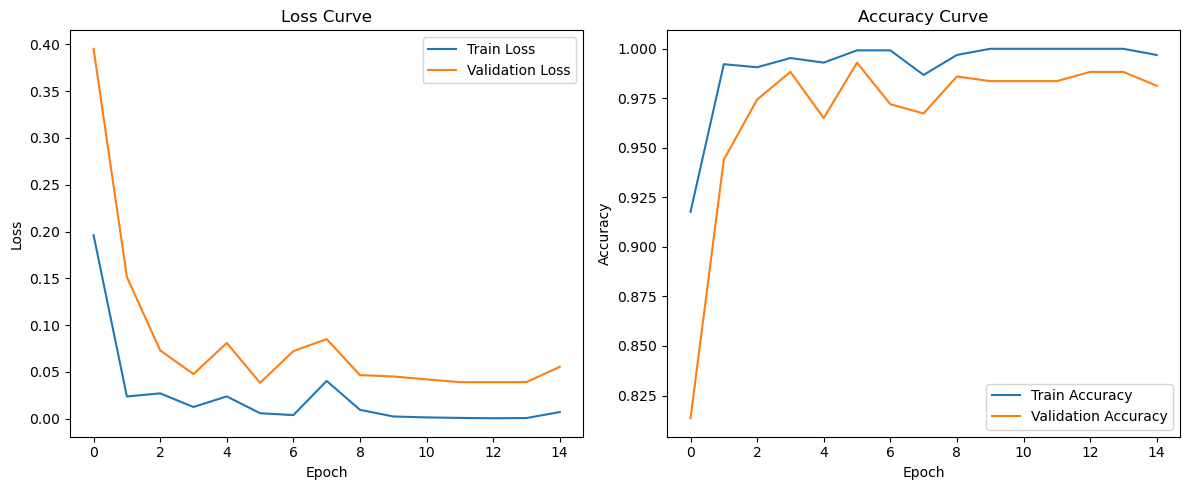

In [8]:
import matplotlib.pyplot as plt
# Plotting the curves
epochs_range = range(EPOCHS)
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(range(0, EPOCHS + 1, 2)) 

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(0, EPOCHS + 1, 2)) 
# save
plt.savefig('ResNet_train-data2.png', dpi=600, bbox_inches='tight')

plt.tight_layout()
plt.show()


<h1>Evaluation</h1>

In [9]:
import pandas as pd
import os
from sklearn.metrics import classification_report
import numpy as np
import torch
from torch.autograd import Variable
import numpy as np
from sklearn.metrics import confusion_matrix

# Load the best model
model.load_state_dict(torch.load('ResNet_best_model_pretrained-data2.pth'))

# Evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = Variable(inputs).to(DEVICE), Variable(labels).to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute and print confusion matrix
conf_matrix = confusion_matrix(np.array(y_true), np.array(y_pred))
print("Confusion Matrix:")
print(conf_matrix)

TP = conf_matrix[0, 0]
TN = conf_matrix[1, 1]
FP = conf_matrix[1, 0]
FN = conf_matrix[0, 1]

print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

accuracy = (TP + TN) / (TP + TN + FP + FN)
F1 = 2*TP/(2*TP + FP + FN)
sensitivity = TP / (TP + FN)
precision = TP / (TP + FP)
specificity = TN / (TN + FP)

print(f"Accuracy: {accuracy:.4f}")
print(f"F-1 Score: {F1:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Specificity: {specificity:.4f}")

# Save results to DataFrame
filenames = [os.path.basename(x[0]) for x in test_loader.dataset.imgs]
class_indices = test_loader.dataset.class_to_idx
indices = {v: k for k, v in class_indices.items()}

val_df = pd.DataFrame({
    'filename': filenames,
    'actual': [indices[x] for x in y_true],
    'predicted': [indices[x] for x in y_pred]
})
val_df['Same'] = val_df['actual'] == val_df['predicted']
val_df = val_df.sample(frac=1).reset_index(drop=True)

print(val_df.head(10))


C:\Users\Administrator\AppData\Local\Temp\ipykernel_11868\1610073048.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ResNet_best_model

Confusion Matrix:
[[245   2]
 [  1 183]]
True Positives (TP): 245
True Negatives (TN): 183
False Positives (FP): 1
False Negatives (FN): 2
Accuracy: 0.9930
F-1 Score: 0.9939
Sensitivity: 0.9919
Precision: 0.9959
Specificity: 0.9946
          filename             actual          predicted  Same
0    siirt 251.jpg    Siirt_Pistachio    Siirt_Pistachio  True
1  kirmizi 745.jpg  Kirmizi_Pistachio  Kirmizi_Pistachio  True
2  kirmizi 264.jpg  Kirmizi_Pistachio  Kirmizi_Pistachio  True
3    siirt 681.jpg    Siirt_Pistachio    Siirt_Pistachio  True
4    siirt 452.jpg    Siirt_Pistachio    Siirt_Pistachio  True
5    siirt 764.jpg    Siirt_Pistachio    Siirt_Pistachio  True
6    siirt 196.jpg    Siirt_Pistachio    Siirt_Pistachio  True
7    siirt 183.jpg    Siirt_Pistachio    Siirt_Pistachio  True
8  kirmizi 868.jpg  Kirmizi_Pistachio  Kirmizi_Pistachio  True
9  kirmizi 955.jpg  Kirmizi_Pistachio  Kirmizi_Pistachio  True


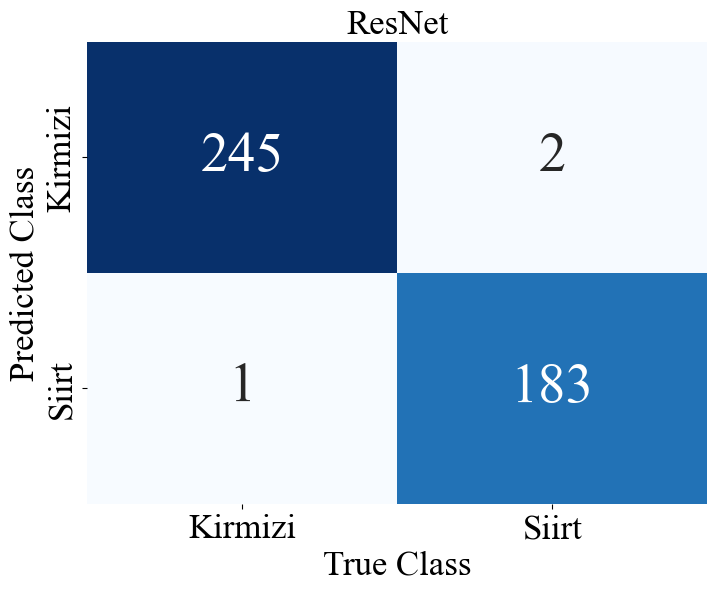

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# set font as Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# plot of confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Kirmizi', 'Siirt'],
            yticklabels=['Kirmizi', 'Siirt'],
            cbar=False, annot_kws={"size": 40})
plt.xlabel('True Class', fontsize=25)
plt.ylabel('Predicted Class', fontsize=25)
plt.title('ResNet', fontsize=25)

ax.tick_params(axis='both', labelsize=25)

# save
plt.savefig('ResNet_confusion_matrix-data2.png', dpi=600, bbox_inches='tight')

plt.show()

<h1>inference time</h1>

In [9]:
import pandas as pd
import os
from sklearn.metrics import classification_report
import numpy as np
import torch
from torch.autograd import Variable
import time  # Import time module
from sklearn.metrics import confusion_matrix

# Load the best model
model.load_state_dict(torch.load('ResNet_best_model_pretrained-data2.pth'))

# Evaluation
model.eval()
y_true, y_pred = [], []

# Record the start time
start_time = time.time()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = Variable(inputs).to(DEVICE), Variable(labels).to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Record the end time
end_time = time.time()

# Calculate inference time
inference_time = (end_time - start_time) / 217
print(f'Inference Time: {inference_time:.4f} seconds')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9052\612224393.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ResNet_best_model_p

Inference Time: 0.0169 seconds
